In [219]:
# try:
#     import dolfinx
# except ImportError:
#     !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a312183/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
#     import dolfinx

In [220]:
# try:
#      import viskex
# except ImportError:
#      !pip3 install "viskex@git+https://github.com/viskex/viskex.git@64c23fe"
#      import viskex

In [221]:
# try:
#     import gmsh
# except ImportError:
#     !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a312183/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
#     import gmsh

In [222]:
import basix.ufl
import dolfinx.fem
import dolfinx.fem.petsc
import dolfinx.io
import gmsh
import mpi4py.MPI
import numpy as np
import numpy.typing
import petsc4py.PETSc # PETSc (the Portable, Extensible Toolkit for Scientific Computation)
import ufl
from mpi4py import MPI

In [223]:
beta = 1e-2
Wi = 0.25

n_elements = 20
dt = 1e-4
num_dt = 400

In [224]:
repeatStr = '_' + str(n_elements) + '_' + str(dt) + '_' + str(num_dt); print(repeatStr);
caseFile = 'output' + '_' + str(n_elements) + '_' + str(dt) + '_' + str(num_dt); print(caseFile);
initFile = caseFile + '/Stress_init' + repeatStr + '.xdmf'; print(initFile);
outFile = caseFile + '/Stress_out' + repeatStr + '.xdmf'; print(outFile);
moreFile = caseFile + '/Stress_more' + repeatStr + '.xdmf'; print(moreFile);
L2File = caseFile + '/L2Err' + repeatStr + '.png'; print(L2File);
H1File = caseFile + '/H1Err' + repeatStr + '.png'; print(H1File);
MaxFile = caseFile + '/MaxErr' + repeatStr + '.png'; print(MaxFile);

_20_0.0001_400
output_20_0.0001_400
output_20_0.0001_400/Stress_init_20_0.0001_400.xdmf
output_20_0.0001_400/Stress_out_20_0.0001_400.xdmf
output_20_0.0001_400/Stress_more_20_0.0001_400.xdmf
output_20_0.0001_400/L2Err_20_0.0001_400.png
output_20_0.0001_400/H1Err_20_0.0001_400.png
output_20_0.0001_400/MaxErr_20_0.0001_400.png


In [225]:
import os
os.makedirs(caseFile)

**1. Geometry & Mesh**

In [226]:
# Unit square domain [0, 1] x [0, 1] with (20,20) mesh elements
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, n_elements, n_elements)

# The resulting mesh object represents the discretized domain on which FEA will be performed
print("mesh.topology.dim = ", mesh.topology.dim)

# Create connectivities required by the rest of the code
mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)

mesh.topology.dim =  2


In [227]:
print("mesh.geometry.dim = ", mesh.geometry.dim)
print("mesh.basix_cell() = ", mesh.basix_cell())

# velocity space element
V_element = basix.ufl.element("Lagrange", mesh.basix_cell(), 2, shape=(mesh.geometry.dim, ))
# Lagrange elements are commonly used for continuous function spaces
# polynomial degree of the Lagrange element is 1

# tensor space element
Q_element = basix.ufl.element("Lagrange", mesh.basix_cell(), 1, shape=(mesh.geometry.dim, mesh.geometry.dim), symmetry=True)
# symmetry=True => symmetric tensor field in case of stress tensor in viscoelastic fluid models

mesh.geometry.dim =  2
mesh.basix_cell() =  CellType.triangle


**2. Function Spaces**

In [228]:
# define the function space
V = dolfinx.fem.functionspace(mesh, V_element)
Q = dolfinx.fem.functionspace(mesh, Q_element)

In [229]:
#!zip -r /content/file.zip /content/test_u.bp
#from google.colab import files
#files.download("/content/file.zip")


In [230]:
# interpolate velocity in the nodal value
class velocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((2, x.shape[1]), dtype=petsc4py.PETSc.ScalarType)
        values[0, :] = np.exp(-0.1*self.t)*np.sin(np.pi*x[0])
        values[1, :] = -np.pi*x[1]* np.cos(np.pi*x[0])*np.exp(-0.1*self.t)
        return values


u = dolfinx.fem.Function(V,name="velocity")
u_eval = velocity(0.0)
# u.interpolate(u_eval): Interpolates the u_eval function over the mesh, setting the values of u at the nodal points according to u_eval.
u.interpolate(u_eval)

with dolfinx.io.VTXWriter(mesh.comm,  f"test_u.bp", u) as vtx_u:
    vtx_u.write(0)
#https://fenicsproject.discourse.group/t/numerical-values-from-ufl-spatialcoordinate/11064/2

**3. Shear Stress Tensor**

In [231]:
x = ufl.SpatialCoordinate(mesh)

def stress(t):
    return ufl.as_tensor([
        [ufl.exp(-0.1 * t) * ufl.sin(ufl.pi * x[0]), -ufl.pi * x[1] * ufl.cos(ufl.pi * x[0]) * ufl.exp(-0.1 * t)],
        [-ufl.pi * x[1] * ufl.cos(ufl.pi * x[0]) * ufl.exp(-0.1 * t), ufl.sin(ufl.pi * x[0]) * ufl.cos(ufl.pi * x[0]) * ufl.exp(-0.1 * t)]
    ])
stress_expr_0 = dolfinx.fem.Expression(stress(0.0), Q.element.interpolation_points())

q_D = dolfinx.fem.Function(Q,name="stress")
q_D.interpolate(stress_expr_0)


**4. Boundary Conditions**

In [232]:
fdim = mesh.topology.dim - 1
boundary_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))
print("boundary_facets = ", boundary_facets)

bc_D = dolfinx.fem.dirichletbc(q_D, dolfinx.fem.locate_dofs_topological(Q, fdim, boundary_facets))

boundary_facets =  [   0    3    4    6   12   14   23   25   37   39   54   56   74   76
   97   99  123  125  152  154  184  186  219  221  257  259  298  300
  342  344  389  391  439  441  492  494  548  550  607  609  668  669
  671  726  728  780  782  831  833  879  881  924  926  966  968 1005
 1007 1041 1043 1074 1076 1104 1106 1131 1133 1155 1157 1176 1178 1194
 1196 1209 1211 1221 1223 1230 1232 1236 1238 1239]


**5. Trial & Test Functions**

In [233]:
psi = ufl.TestFunction(Q)
tau = ufl.TrialFunction(Q)
dx=ufl.Measure("dx", domain=mesh, metadata={"quadrature_degree": 10})

**6. Initial Condition**

In [234]:
# Create initial condition
q_n = dolfinx.fem.Function(Q)
q_n.name = "q_n"
q_n.interpolate(stress_expr_0)

with dolfinx.io.XDMFFile(mesh.comm, initFile, "w", encoding=dolfinx.io.XDMFFile.Encoding.ASCII) as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(q_n)

In [235]:
formulation_one = False
if formulation_one:

  F = ufl.inner(tau,psi)*dx - dt*ufl.inner(ufl.dot(2*ufl.skew(ufl.grad(u)), tau),psi)*dx
  # transport part
  F+= dt*ufl.inner(ufl.dot(u,ufl.grad(tau)), psi)*dx

  # to complete here there is kappa factor..
  h = ufl.CellDiameter(mesh)
  # beta = 1e-2
  stab  = beta* dt*h* ufl.inner(ufl.grad(tau),ufl.grad(psi))*dx
  F+=stab

  # see stabilization implemented PLS for the stress- need stabilization since it esplode!!
  # PhD thesis
  #https://orca.cardiff.ac.uk/id/eprint/118620/1/Theoretical%20and%20Computational%20Modelling%20of%20Compressible%20Viscoelastic%20Fluids%20-%20Alex%20Mackay%202018.pdf
  # Code
  #https://github.com/ATMackay/fenics/blob/master/lid-driven-cavity/comp_LDC.py
  L = 1/Wi *dt* (ufl.inner(ufl.Identity(mesh.geometry.dim),psi)*dx - ufl.inner(2*ufl.skew(ufl.grad(u)),psi)*dx  )
  L += 1/Wi* ufl.inner(q_n,psi)*dx

In [236]:
def ConvectStress(u, tau):
   return ufl.dot(u,ufl.grad(tau)) - ufl.dot(ufl.grad(u), tau) - ufl.dot(tau, ufl.grad(u))
    
# Full implicit
lhs = Wi/dt*tau + tau + Wi* ConvectStress(u,tau)
rhs = Wi/dt* q_n +  ufl.Identity(len(u))

# explicit 
# lhs = Wi/dt*tau
# rhs = Wi/dt* q_n +  ufl.Identity(len(u)) - q_n - Wi* ConvectStress(u,q_n)

F = ufl.inner(lhs, psi)*dx
L = ufl.inner(rhs,psi)*dx

# SUPG stabilization
h = ufl.CellDiameter(mesh)
magnitudeVel = ufl.sqrt(ufl.dot(u,u))

alpha_supg = h /(magnitudeVel + 1e-6)
 
supgL = ufl.inner(rhs,alpha_supg *ufl.dot(u, ufl.grad(psi)))*dx
supgF = ufl.inner(lhs,alpha_supg *ufl.dot(u, ufl.grad(psi)))*dx
 
#F += supgF 
#L += supgL

# reg =1e-6
# alpha_supg = h /(magnitudeVel+reg)
# supg = ufl.inner( Wi*ufl.dot(u,ufl.grad(tau)), alpha_supg *ufl.dot(u, ufl.grad(psi)) )*dx
# F += supg

In [237]:
def convergence(uh,uexact):
    
    error_local = dolfinx.fem.assemble_scalar(dolfinx.fem.form((uh - uexact)**2 * ufl.dx))
    error_localH10 = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(ufl.grad(uh - uexact), ufl.grad(uh-uexact)) * ufl.dx) )
    # error_localH1 = dolfinx.fem.assemble_scalar(dolfinx.fem.form((uh - uexact)**2 * ufl.dx + ufl.grad(uh - q_D)**2 * ufl.dx) )
    
    error_L2 = numpy.sqrt(mesh.comm.allreduce(error_local, op=MPI.SUM))
    error_H1 =  numpy.sqrt(mesh.comm.allreduce(error_localH10, op=MPI.SUM))
    
    if mesh.comm.rank == 0:
        print(f"L2-error: {error_L2:.2e}")
        print(f"H1-error: {error_H1:.2e}")
        
    # Compute values at mesh vertices
    error_max = mesh.comm.allreduce(numpy.max(numpy.abs(uh.x.array - uexact.x.array)), op=MPI.MAX)
    
    if mesh.comm.rank == 0:
        print(f"Error_max: {error_max:.2e}")
    
    return error_max,error_L2,error_H1

In [238]:
from dolfinx.fem.petsc import LinearProblem

error = dolfinx.fem.Function(Q,name="error")
xdmf = dolfinx.io.XDMFFile(mesh.comm, outFile, "w", encoding=dolfinx.io.XDMFFile.Encoding.ASCII)
xdmf.write_mesh(mesh)

t = 0

xdmf.write_function(q_n,t)

problem = LinearProblem(F, L, bcs=[bc_D], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "ksp_rtol": 1e-10})

# additional flags to have MUMPS as preconditioner
problem.solver.getPC().setFactorSolverType("mumps")
opts = petsc4py.PETSc.Options()
opts["mat_mumps_icntl_14"] = 80  # Increase MUMPS working memory
opts["ksp_error_if_not_converged"] = 1
opts["ksp_monitor"] = None
problem.solver.setFromOptions() 

error = dict()
error["L2"]=[]
error["H1"]=[]
error["max"]=[]

q_exact  = dolfinx.fem.Function(Q)
for n in range(num_dt):

    print('Time Step = ', n)
    t+=dt
    u_eval.t =  t
    u.interpolate(u_eval)
    stress_expr_t = dolfinx.fem.Expression(stress(t), Q.element.interpolation_points())
    
    q_exact.interpolate(stress_expr_t)
    q_D.interpolate(stress_expr_t)
    
    qh = problem.solve()
    qh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    q_n.x.array[:] = qh.x.array
    q_n.name="stress"
    xdmf.write_function(q_n,t)
    
    error_max,error_L2,error_H1 = convergence(q_n,q_exact)
    error["L2"].append(error_L2)
    error["H1"].append(error_H1)
    error["max"].append(error_max)

xdmf.close()

Time Step =  0
L2-error: 1.03e-03
H1-error: 1.70e-02
Error_max: 3.41e-03
Time Step =  1
L2-error: 2.06e-03
H1-error: 3.39e-02
Error_max: 6.81e-03
Time Step =  2
L2-error: 3.09e-03
H1-error: 5.08e-02
Error_max: 1.02e-02
Time Step =  3
L2-error: 4.12e-03
H1-error: 6.78e-02
Error_max: 1.35e-02
Time Step =  4
L2-error: 5.15e-03
H1-error: 8.47e-02
Error_max: 1.69e-02
Time Step =  5
L2-error: 6.18e-03
H1-error: 1.02e-01
Error_max: 2.02e-02
Time Step =  6
L2-error: 7.20e-03
H1-error: 1.18e-01
Error_max: 2.35e-02
Time Step =  7
L2-error: 8.23e-03
H1-error: 1.35e-01
Error_max: 2.68e-02
Time Step =  8
L2-error: 9.25e-03
H1-error: 1.52e-01
Error_max: 3.01e-02
Time Step =  9
L2-error: 1.03e-02
H1-error: 1.69e-01
Error_max: 3.34e-02
Time Step =  10
L2-error: 1.13e-02
H1-error: 1.86e-01
Error_max: 3.66e-02
Time Step =  11
L2-error: 1.23e-02
H1-error: 2.03e-01
Error_max: 3.98e-02
Time Step =  12
L2-error: 1.33e-02
H1-error: 2.20e-01
Error_max: 4.30e-02
Time Step =  13
L2-error: 1.44e-02
H1-error: 2.3

In [239]:
# we need to do the static case now..

stress_expr_t = dolfinx.fem.Expression(stress(t), Q.element.interpolation_points())
qexact = dolfinx.fem.Function(Q)
qexact.interpolate(stress_expr_t)
error_max,error_L2,error_H1 = convergence(q_n,qexact)

L2-error: 3.66e-01
H1-error: 7.36e+00
Error_max: 8.73e-01


In [240]:
with dolfinx.io.XDMFFile(mesh.comm, moreFile, "w", encoding=dolfinx.io.XDMFFile.Encoding.ASCII) as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(q_n)
    xdmf.write_function(q_D)

In [241]:
#CFL
vnorm_form = ufl.dot(u,u)
vnorm_local= dolfinx.fem.assemble_scalar(dolfinx.fem.form(vnorm_form*ufl.dx))
vnorm = numpy.sqrt(mesh.comm.allreduce(vnorm_local, op=MPI.SUM))
tdim = mesh.topology.dim
num_cells = mesh.topology.index_map(tdim).size_local
cells = np.arange(num_cells, dtype=np.int32)
meshcpp = dolfinx.cpp.mesh.Mesh_float64(mesh.comm, mesh.topology, mesh.geometry)
h = dolfinx.cpp.mesh.h(meshcpp, tdim, cells)

In [242]:
print(np.max(h)/vnorm)

0.04847474402265651


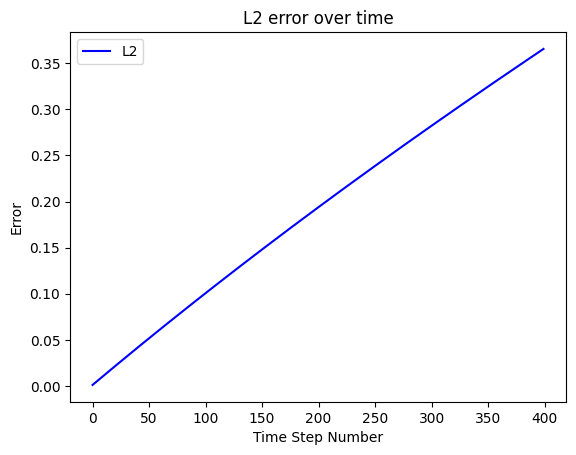

In [243]:
# Plotting the results
import matplotlib.pyplot as plt
plt.plot(error["L2"], 'b', label='L2')
plt.legend()
plt.title("L2 error over time")
plt.xlabel('Time Step Number')
plt.ylabel('Error')
# plt.xticks(range(0, len(error["L2"])+1, 1))
plt.savefig(L2File)
plt.show()

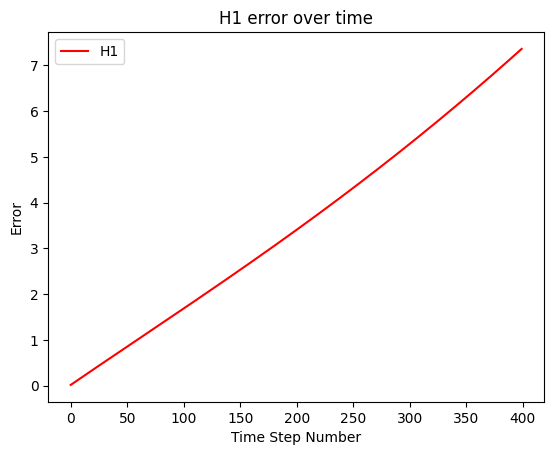

In [244]:
# Plotting the results
import matplotlib.pyplot as plt
plt.plot(error["H1"], 'r', label='H1')
plt.legend()
plt.title("H1 error over time")
plt.xlabel('Time Step Number')
plt.ylabel('Error')
# plt.xticks(range(0, len(error["L2"])+1, 1))
plt.savefig(H1File)
plt.show()

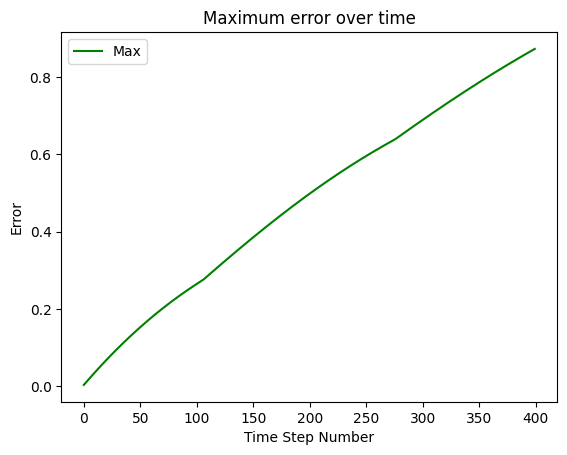

In [245]:
# Plotting the results
import matplotlib.pyplot as plt
plt.plot(error["max"], 'g', label='Max')
plt.legend()
plt.title("Maximum error over time")
plt.xlabel('Time Step Number')
plt.ylabel('Error')
# plt.xticks(range(0, len(error["L2"])+1, 1))
plt.savefig(MaxFile)
plt.show()